In [3]:
import pandas as pd
data = pd.read_csv('Flowster_Topic_Attributes_20200609181520.csv')
data.head()

,Unnamed: 0,Topic Title,Category,Tags,Author,Commenters,Leading Comment,Other Comments,Likes,Views
0,0,About the Product Sourcing Category,Product Sourcing,[],Trent-Admin,[],Have questions about sourcing products? This i...,[],0,0
1,1,Price Checker 2 - Competitor storefront extrac...,Product Sourcing,[],MoniqueAndKerry,['Mitch'],Hi! We are new to the forum and are going thro...,['Yes you will need the paid version. Options...,0,24
2,2,Top 10 Tips to Grow your Business Rapidly,Product Sourcing,['Purchasing'],Pradimna_Kumar,[],As I am working in Amazon as a seller from las...,[],0,0
3,3,Virtual Assistants,Product Sourcing,[],JimW_PB,"['Rebca', 'McDavid', 'Mitch']","Does anyone have a VA they recommend, have use...",['@McDavid Most don’t want to share any stella...,0,147
4,4,Can you sell branded products on Amazon uk,Product Sourcing,['Sourcing Brand Name Products'],Mitch,['Rameksuya'],Can you sell branded products on Amazon Uk or ...,['You can sell on Amazon UK as well. It could...,0,73


In [4]:
data.columns

Index(['Unnamed: 0', 'Topic Title', 'Category', 'Tags', 'Author', 'Commenters',
       'Leading Comment', 'Other Comments', 'Likes', 'Views'],
      dtype='object')

In [5]:
data.drop(columns= ['Unnamed: 0', 'Tags', 'Commenters','Likes', 'Views'], inplace=True)

In [6]:
data.head()

,Topic Title,Category,Author,Leading Comment,Other Comments
0,About the Product Sourcing Category,Product Sourcing,Trent-Admin,Have questions about sourcing products? This i...,[]
1,Price Checker 2 - Competitor storefront extrac...,Product Sourcing,MoniqueAndKerry,Hi! We are new to the forum and are going thro...,['Yes you will need the paid version. Options...
2,Top 10 Tips to Grow your Business Rapidly,Product Sourcing,Pradimna_Kumar,As I am working in Amazon as a seller from las...,[]
3,Virtual Assistants,Product Sourcing,JimW_PB,"Does anyone have a VA they recommend, have use...",['@McDavid Most don’t want to share any stella...
4,Can you sell branded products on Amazon uk,Product Sourcing,Mitch,Can you sell branded products on Amazon Uk or ...,['You can sell on Amazon UK as well. It could...


In [7]:
len(data['Other Comments'][data['Other Comments'] == '[]'])

46

# Explore the data

In [8]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

In [9]:
df = data.copy()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 5 columns):
Topic Title        261 non-null object
Category           261 non-null object
Author             261 non-null object
Leading Comment    260 non-null object
Other Comments     261 non-null object
dtypes: object(5)
memory usage: 10.3+ KB


In [11]:

df['post'] = df['Author'] + ' ' + df['Topic Title'] + ' ' + df['Leading Comment'] + ' ' + df['Other Comments']

In [12]:
df.post[0]

'Trent-Admin About the Product Sourcing Category Have questions about sourcing products? This is the category to use. Please be sure to select the most appropriate sub-category for your questions. []'

In [13]:
df.post.head()

0    Trent-Admin About the Product Sourcing Categor...
1    MoniqueAndKerry Price Checker 2 - Competitor s...
2    Pradimna_Kumar Top 10 Tips to Grow your Busine...
3    JimW_PB Virtual Assistants Does anyone have a ...
4    Mitch Can you sell branded products on Amazon ...
Name: post, dtype: object

In [14]:
df.post[2]

'Pradimna_Kumar Top 10 Tips to Grow your Business Rapidly As I am working in Amazon as a seller from last 6 years do you want some tips for selling and growing your business fastly like how I grow my business this are some tips, please read carefully :-\nTop 10 Amazon Selling Tips\n\n\nOptimize Product Details for Search\n\n\nUse Competitive Pricing\n\n\nTake Professional Product Images\n\n\nTry to Own the Buy Box\n\n\nWork to Continually Improve Your Performance\n\n\nConsider Using Fulfillment by Amazon\n\n\nFollow Amazon’s Rules\n\n\nLeverage Product Reviews to Your Advantage\n\n\nMake Customer Service a Top Priority\n\n\nManage Amazon Inventory Proactively\n\n []'

In [15]:
df['Category'].unique()

array(['Product Sourcing', 'Human Resources', 'Amazon Specific',
       'Flowster-specific', 'Software & Tools', 'Fulfillment',
       'Traffic Sources', 'Management', 'Misc Topics',
       'Financial Management', 'eCommerce Marketplaces',
       'Store & Website Management'], dtype=object)

In [16]:
my_categories = ['Product Sourcing', 'Human Resources', 'Amazon Specific',
       'Flowster-specific', 'Software & Tools', 'Fulfillment',
       'Traffic Sources', 'Management', 'Misc Topics',
       'Financial Management', 'eCommerce Marketplaces',
       'Store & Website Management']

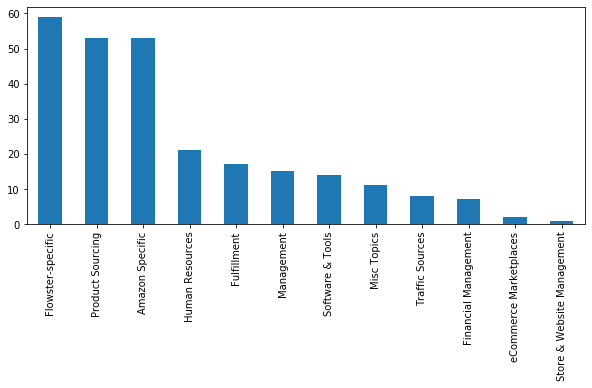

In [17]:
plt.figure(figsize=(10,4))
df.Category.value_counts().plot(kind='bar');

We have data imbalance.

In [18]:
def print_plot(index):
    example = df[df.index == index][['post', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])
print_plot(10)

Dennis_Scheurich Selling books my question is : when selling books, the pricing for paperback books is for some reason a lot lower than the mass market prices even though the mass market books are supposedly of lesser quality. why is this ? ['@Dennis_Scheurich I would assume it is a supply/demand issue.  I’m not sure what the demand between traditional paperback and mass market is but I would imagine there is less demand for the mass market based off your statement and some Amazon forum threads.\nJust like any other listing with variations, sellers are going to gravitate to the highest selling variation and prices are going to drop as a result.', 'hello mitch. thanks for the quick response. that makes sense. i never thought of it that way.', 'Anytime @Dennis_Scheurich.  Do you have any other theories as to why this would be?  It would be nice if some others with experience in selling books would chime in here.']
Category: Product Sourcing


# Modeling before preprocessing

In [19]:
pd.isnull(df.post).sum()

1

In [20]:
df.isnull().sum()

Topic Title        0
Category           0
Author             0
Leading Comment    1
Other Comments     0
post               1
dtype: int64

In [21]:
df.post.dropna(axis = 0 ,  how = 'all', inplace=True)

In [22]:
df['post'][df.post.isnull()]

Series([], Name: post, dtype: object)

In [23]:
df = df.dropna ()
df = df.reset_index(drop=True)

In [24]:
df['post'][df.post.isnull()]

Series([], Name: post, dtype: object)

In [25]:
df['post'][245:]

245    Laura Podcasts \n\nTrent mentioned to listen t...
246    Laura Exclusive With Brands I have a brand tha...
247    Bruce_MacDonald U.S. Warehousing necessary as ...
248    Laura Dealing With Idiots Anyone have any crea...
249    VonT Emailing from Hubspot It looks like to me...
250    Kane About the Financial Management category H...
251    Lazar Cashback cards for non US citizens? When...
252    APlusSeller Purchase Orders for Bundles Good M...
253    dast1983 Sales tax I’m pretty set with sales t...
254    dast1983 Tracking COGs beyond Amazon Hi -\nI’m...
255    terrifetters Tracking COGS Hello,\nDoes anyone...
256    BetterLifeSales Accounting Software What accou...
257    Trent-Admin About the Sales Channels & Marketp...
258    Laura Storefront Question If I am posting this...
259    Kane About the Store & Website Management cate...
Name: post, dtype: object

In [26]:
X = df.post
y = df.Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 42)

In [27]:
X_train.head()

172    Kane Uploading Image from Evernote I can’t fin...
29     Daniel_Folkmanas Brand Exclusivity Hello Commu...
195    ridethewave Website to show suppliers Hi @Tren...
175    MattB Workflow question Can you delete a workf...
194    mricozzi104 Email Account Organization Ok a re...
Name: post, dtype: object

In [28]:
len(y_train.unique())

12

In [29]:
len(my_categories)

12

In [30]:
len(y_test.unique())

11

In [31]:
y_train.unique()

array(['Flowster-specific', 'Product Sourcing', 'Software & Tools',
       'Human Resources', 'Amazon Specific', 'Traffic Sources',
       'Fulfillment', 'Misc Topics', 'Management', 'Financial Management',
       'eCommerce Marketplaces', 'Store & Website Management'],
      dtype=object)

In [32]:
y_test.unique() #'Store & Website Management'

array(['Product Sourcing', 'Flowster-specific', 'Traffic Sources',
       'Fulfillment', 'eCommerce Marketplaces', 'Amazon Specific',
       'Software & Tools', 'Misc Topics', 'Management', 'Human Resources',
       'Financial Management'], dtype=object)

In [33]:
y_train[y_train == 'Store & Website Management']

259    Store & Website Management
Name: Category, dtype: object

In [34]:
#y_test.append(y_train[y_train == 'Store & Website Management'])

In [35]:
X_train[X_train =='Kane About the Store & Website Management category Have questions about Store & Website Management? This is the category to use. Please be sure to select the most appropriate sub-category for your questions. []' ]

259    Kane About the Store & Website Management cate...
Name: post, dtype: object

In [36]:
y_test

30         Product Sourcing
181       Flowster-specific
223         Traffic Sources
185       Flowster-specific
211             Fulfillment
               ...         
84          Amazon Specific
127       Flowster-specific
183       Flowster-specific
86          Amazon Specific
250    Financial Management
Name: Category, Length: 86, dtype: object

In [37]:
X_test

30     grant Email Sourcing Zoom Meeting Hello Bright...
181    Kane Using Follow-Up To Set Up Customer Follow...
223    MBahe Generate traffic to product listings Wha...
185    Kane Flowster User Forum Hello Kane - I just w...
211    Brandon_Bouchereau California Prep Center reco...
                             ...                        
84     zaid Received email that said ODR is > 1% We j...
127    system About the Flowster-specific category Di...
183    debi_zyx How can I move or copy a task from on...
86     Mitch Seller Legend: compare month-over-month ...
250    Kane About the Financial Management category H...
Name: post, Length: 86, dtype: object

In [38]:
y_train.unique()

array(['Flowster-specific', 'Product Sourcing', 'Software & Tools',
       'Human Resources', 'Amazon Specific', 'Traffic Sources',
       'Fulfillment', 'Misc Topics', 'Management', 'Financial Management',
       'eCommerce Marketplaces', 'Store & Website Management'],
      dtype=object)

In [39]:
len(y_train.unique())

12

In [40]:
len(y_test.unique())

11

In [41]:
categories = ['Flowster-specific', 'Product Sourcing', 'Software & Tools',
       'Human Resources', 'Amazon Specific', 'Traffic Sources',
       'Fulfillment', 'Misc Topics', 'Management', 'Financial Management',
       'eCommerce Marketplaces']

## Logistic Regression

In [42]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logreg = Pipeline([('vect', TfidfVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict (X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
res21 = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=categories))

accuracy 0.5930232558139535
                        precision    recall  f1-score   support

     Flowster-specific       0.57      0.62      0.59        21
      Product Sourcing       0.00      0.00      0.00         2
      Software & Tools       0.67      0.90      0.77        20
       Human Resources       1.00      0.43      0.60         7
       Amazon Specific       0.57      0.57      0.57         7
       Traffic Sources       0.75      0.60      0.67         5
           Fulfillment       0.00      0.00      0.00         3
           Misc Topics       0.45      0.67      0.54        15
            Management       0.00      0.00      0.00         3
  Financial Management       0.00      0.00      0.00         2
eCommerce Marketplaces       0.00      0.00      0.00         1

              accuracy                           0.59        86
             macro avg       0.36      0.34      0.34        86
          weighted avg       0.54      0.59      0.55        86



/opt/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Text preprocessing

In [43]:
test_df = df.copy()

In [44]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\'\“\”\’\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
import string
punct = string.punctuation

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = text.replace(r'\n', ' ')
    #text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ''.join(word for word in text if word not in punct)  # remove punctuation
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
test_df['post'] = test_df['post'].apply(clean_text)

In [45]:
def test_print_plot(index):
    example = test_df[test_df.index == index][['post', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])
test_print_plot(10)

dennisscheurich selling books question selling books pricing paperback books reason lot lower mass market prices even though mass market books supposedly lesser quality dennisscheurich would assume supply demand issue sure demand traditional paperback mass market would imagine less demand mass market based statement amazon forum threads like listing variations sellers going gravitate highest selling variation prices going drop result hello mitch thanks quick response makes sense never thought way anytime dennisscheurich theories would would nice others experience selling books would chime
Category: Product Sourcing


## Modeling after preprocessing

In [46]:
X = test_df.post
y = test_df.Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 42)

In [47]:
logreg = Pipeline([('vect', TfidfVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict (X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
res31 = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=categories))

accuracy 0.5813953488372093
                        precision    recall  f1-score   support

     Flowster-specific       0.57      0.57      0.57        21
      Product Sourcing       0.00      0.00      0.00         2
      Software & Tools       0.70      0.95      0.81        20
       Human Resources       1.00      0.43      0.60         7
       Amazon Specific       0.50      0.43      0.46         7
       Traffic Sources       0.75      0.60      0.67         5
           Fulfillment       0.00      0.00      0.00         3
           Misc Topics       0.42      0.67      0.51        15
            Management       0.00      0.00      0.00         3
  Financial Management       0.00      0.00      0.00         2
eCommerce Marketplaces       0.00      0.00      0.00         1

              accuracy                           0.58        86
             macro avg       0.36      0.33      0.33        86
          weighted avg       0.54      0.58      0.54        86



/opt/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


- accuracy `0.5813953488372093` **#text = BAD_SYMBOLS_RE.sub('', text): commented**
- accuracy `0.5581395348837209` **#text = BAD_SYMBOLS_RE.sub('', text) : uncommented**

# Data Augmentation

I am using this library : https://github.com/makcedward/nlpaug

In [48]:
#!pip install nlpaug

In [49]:
#!pip install nlpaug numpy matplotlib python-dotenv

In [50]:
#import nlpaug
#from nlpaug.util.file.download import DownloadUtil

#DownloadUtil.download_word2vec(dest_dir='.') # Download word2vec model
#DownloadUtil.download_glove(model_name='glove.6B', dest_dir='.') # Download GloVe model
#DownloadUtil.download_fasttext(model_name='wiki-news-300d-1M', dest_dir='.') # Download fasttext model

In [1]:
pwd

'/Users/mac/Desktop/sideProjects/STEMAway/mlteam4/flowster_webscraping'

In [57]:
import os
os.environ["MODEL_DIR"] = '../../nlpaug/model/'

In [52]:
ls '../../nlpaug/model'

char/            spelling_en.txt*


In [53]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [54]:
text = 'The quick brown fox jumps over the lazy dog .'
print(text)

The quick brown fox jumps over the lazy dog .


In [58]:
aug = naw.SpellingAug(os.environ["MODEL_DIR"] + 'spelling_en.txt')
augmented_texts = aug.augment(text, n=3)
print("Original:")
print(text)
print("Augmented Texts:")
print(augmented_texts)

Original:
The quick brown fox jumps over the lazy dog .
Augmented Texts:
['The quick brown fox jumps overt hthe laze dog .', 'The quick browm fox jumps other tne lazy dog .', 'They quick brown fox jumps over that laizy dog .']


In [69]:
pwd

'/Users/mac/Desktop/sideProjects/STEMAway/mlteam4/flowster_webscraping'

In [70]:
ls

AmazonWebscraper.py
DataCleaning (Kitty).ipynb
Data_Augmentation_Trial_SaraE.ipynb
FlowsterWebscraper.py
Flowster_Topic_Attributes_20200609181520.csv
Flowster_Topic_Attributes_20200609181520.json
GoogleNews-vectors-negative300
GoogleNews-vectors-negative300.zip
archive/
glove.6B.100d.txt
glove.6B.200d.txt
glove.6B.300d.txt
glove.6B.50d.txt
glove.6B.zip
textual_augmenter-Copy1.ipynb
wiki-news-300d-1M.vec
wiki-news-300d-1M.vec.zip


In [ ]:
## Takes a lot of time
# model_type: word2vec, glove or fasttext
model_dir = os.environ.get("MODEL_DIR")
aug = naw.WordEmbsAug(
    model_type='word2vec', model_path='GoogleNews-vectors-negative300',
    action="substitute")
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

In [102]:
aug = naw.TfIdfAug(
    model_path=os.environ.get("MODEL_DIR"),
    action="substitute")
text = 'zaid black box amazon product arcing yay nay heard pastel things tool pageshelium10com black box amazon product finder research DuPont SSM2016 10 black box gives amazon sellers '
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
zaid black box amazon product arcing yay nay heard pastel things tool pageshelium10com black box amazon product finder research DuPont SSM2016 10 black box gives amazon sellers 
Augmented Text:
zaid black Xsi amazon product Gaspra yay geographical heard pastel things tool pageshelium10com 6EIQX halftoning amazon product finder tes Tutorial SSM2016 tingled black box gives amazon sellers


In [74]:
!pip install pytorch_pretrained_bert>=1.1.0

In [96]:
!pip install transformers

In [97]:
import transformers
print(transformers.__version__)

2.11.0


In [ ]:
# Need to change to GPU which I don't have locally
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute")
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

## Augmenting the data using TF-IDF

**The 20 newsgroups text dataset**  

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.

`sklearn.datasets.fetch_20newsgroups`, returns a list of the raw texts that can be fed to text feature extractors such as `sklearn.feature_extraction.text.CountVectorizer` with custom parameters so as to extract feature vectors.

Data Set Characteristics:
- **Classes** 20
- **Samples total** 18846
- **Dimensionality** 1
- **Features** text

Link: https://scikit-learn.org/stable/datasets/index.html

In [112]:
import sklearn.datasets
import re

import nlpaug.augmenter.word as naw
import nlpaug.model.word_stats as nmw

def _tokenizer(text, token_pattern=r"(?u)\b\w\w+\b"):
    token_pattern = re.compile(token_pattern)
    return token_pattern.findall(text)

# Load sample data
train_data = sklearn.datasets.fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
train_x = train_data.data

# Tokenize input
train_x_tokens = [_tokenizer(x) for x in train_x]

# Train TF-IDF model
tfidf_model = nmw.TfIdf()
tfidf_model.train(train_x_tokens)
tfidf_model.save('.')

# Load TF-IDF augmenter
aug = naw.TfIdfAug(model_path='.', tokenizer=_tokenizer)

texts = test_df.post

augmented_text = []

for text in texts:
    augmented_text.append(aug.augment(text))
    
    #print('-'*20)
    #print('Original Input:{}'.format(text))
    #print('Agumented Output:{}'.format(augmented_text))

In [99]:
len(augmented_text)

260

In [166]:
test_df.post[1]

'moniqueandkerry price checker 2 competitor storefront extraction hi new forum going product sourcing professionals sops question product extraction workflow process using pc2 downloaded free version button says ‘amazon browser searches need purchase full pc2 package get feature thanks help advance yes need paid version options extraction tools include pc2 tactical arbitrage helium10 require paid version run scale'

In [165]:
augmented_text[1]

'moniqueandkerry price checker competitor storefront reentry hi new FloppyDiskDrives going Hosts 1208 professionals sops question product Engima workflow 6UL46 using pc2 downloaded free version button says amazon browser searches Ratelle purchase soapy pc2 Boosters get feature thanks help advance yes need paid version options extraction tools include pc2 tactical arbitrage helium10 require paid RNKI run scale'

In [100]:
augmented_text[:10]

['trentadmin product sourcing category congratulate sourcing products category mayne Senner sure HTVQ_LL appropriate subcategory questions',
 'moniqueandkerry price checker competitor storefront extraction hi new forum PROTMAN product sourcing professionals sops question product extraction workflow process using pc2 Bocharov YN version button says amazon browser searches need purchase full pc2 package get feature thanks uninvolved advance bulldada Q0 formalities version slicer extraction tools include pc2 tactical arbitrage helium10 Woodlice paid version run augment',
 'pradimnakumar top 10 tips grow business rapidly 32JR amazon seller last Russ want tips PIHXK growing business fastly like grow business tips please read carefully miscellaneous 10 amazon selling tips optimize product details search use competitive pricing take professional product images try buy qemm work continually improve performance k044477 using fulfillment amazon follow amazon rules leverage product Mordechai adva

In [133]:
aug_data = pd.DataFrame({'Augmented Post': augmented_text})

In [134]:
aug_data

,Augmented Post
0,trentadmin product Suttles category MCC sourci...
1,moniqueandkerry price checker competitor store...
2,pradimnakumar top 10 tips grow business rapidl...
3,jimwpb virtual assistants anyone va recommend ...
4,SRAM emphases branded products amazon uk sell ...
...,...
255,terrifetters tracking cogs hello anyone advise...
256,betterlifesales breaths software 804 software ...
257,trentadmin introduced Pundurs marketplaces fra...
258,laura storefront question posting wrong place ...


In [135]:
aug_data['Category'] = test_df.Category

In [136]:
test_df.head()

,Category,post
0,Product Sourcing,trentadmin product sourcing category questions...
1,Product Sourcing,moniqueandkerry price checker 2 competitor sto...
2,Product Sourcing,pradimnakumar top 10 tips grow business rapidl...
3,Product Sourcing,jimwpb virtual assistants anyone va recommend ...
4,Product Sourcing,mitch sell branded products amazon uk sell bra...


In [ ]:
test_df.drop(columns=['Topic Title', 'Author', 'Leading Comment', 'Other Comments'], inplace=True)

In [138]:
test_df.head()

,Category,post
0,Product Sourcing,trentadmin product sourcing category questions...
1,Product Sourcing,moniqueandkerry price checker 2 competitor sto...
2,Product Sourcing,pradimnakumar top 10 tips grow business rapidl...
3,Product Sourcing,jimwpb virtual assistants anyone va recommend ...
4,Product Sourcing,mitch sell branded products amazon uk sell bra...


In [139]:
aug_data.head()

,Augmented Post,Category
0,trentadmin product Suttles category MCC sourci...,Product Sourcing
1,moniqueandkerry price checker competitor store...,Product Sourcing
2,pradimnakumar top 10 tips grow business rapidl...,Product Sourcing
3,jimwpb virtual assistants anyone va recommend ...,Product Sourcing
4,SRAM emphases branded products amazon uk sell ...,Product Sourcing


In [140]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\'\“\”\’\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
import string
punct = string.punctuation

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = text.replace(r'\n', ' ')
    #text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ''.join(word for word in text if word not in punct)  # remove punctuation
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
aug_data['Augmented Post'] = aug_data['Augmented Post'].apply(clean_text)

In [141]:
def test_print_plot(index):
    example = aug_data[aug_data.index == index][['Augmented Post', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])
test_print_plot(10)

dennisscheurich selling books question selling books dime paperback xlqs4 reason lot lower mass market prices arguement though innately rrn books supposedly lesser quality dennisscheurich would assume supply 90mb issue sure demand gangsters paperback mass market would imagine less demand mass market based statement amazon forum threads like listing variations sellers going gravitate highest selling variation prices going drop result hello mitch thanks quick response makes condoms never thought way anytime dennisscheurich theories b747 would nice others experience selling microcontrollers would chime
Category: Product Sourcing


In [142]:
aug_data.head()

,Augmented Post,Category
0,trentadmin product suttles category mcc sourci...,Product Sourcing
1,moniqueandkerry price checker competitor store...,Product Sourcing
2,pradimnakumar top 10 tips grow business rapidl...,Product Sourcing
3,jimwpb virtual assistants anyone va recommend ...,Product Sourcing
4,sram emphases branded products amazon uk sell ...,Product Sourcing


In [144]:
aug_data.rename(columns={"Augmented Post": "post"}, inplace=True)

In [152]:
result = test_df.append(aug_data, ignore_index=True, sort=False)

In [155]:
result

,Category,post
0,Product Sourcing,trentadmin product sourcing category questions...
1,Product Sourcing,moniqueandkerry price checker 2 competitor sto...
2,Product Sourcing,pradimnakumar top 10 tips grow business rapidl...
3,Product Sourcing,jimwpb virtual assistants anyone va recommend ...
4,Product Sourcing,mitch sell branded products amazon uk sell bra...
...,...,...
515,Financial Management,terrifetters tracking cogs hello anyone advise...
516,Financial Management,betterlifesales breaths software 804 software ...
517,eCommerce Marketplaces,trentadmin introduced pundurs marketplaces fra...
518,eCommerce Marketplaces,laura storefront question posting wrong place ...


In [154]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 2 columns):
Category    520 non-null object
post        520 non-null object
dtypes: object(2)
memory usage: 8.2+ KB


### Modeling the augmented data

In [156]:
X = result.post
y = result.Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 42)

In [157]:
logreg = Pipeline([('vect', TfidfVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict (X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
res31 = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=categories))

accuracy 0.8430232558139535
                        precision    recall  f1-score   support

     Flowster-specific       0.75      1.00      0.86        36
      Product Sourcing       1.00      0.20      0.33         5
      Software & Tools       0.89      1.00      0.94        33
       Human Resources       1.00      0.75      0.86         8
       Amazon Specific       0.87      0.76      0.81        17
       Traffic Sources       1.00      0.89      0.94         9
           Fulfillment       1.00      0.78      0.88         9
           Misc Topics       0.86      0.79      0.82        38
            Management       0.70      0.78      0.74         9
  Financial Management       0.50      1.00      0.67         1
eCommerce Marketplaces       1.00      0.43      0.60         7

              accuracy                           0.84       172
             macro avg       0.87      0.76      0.77       172
          weighted avg       0.86      0.84      0.83       172



/opt/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


**Before augmenting**

                        precision    recall  f1-score   support

     Flowster-specific       0.57      0.57      0.57        21
      Product Sourcing       0.00      0.00      0.00         2
      Software & Tools       0.70      0.95      0.81        20
       Human Resources       1.00      0.43      0.60         7
       Amazon Specific       0.50      0.43      0.46         7
       Traffic Sources       0.75      0.60      0.67         5
           Fulfillment       0.00      0.00      0.00         3
           Misc Topics       0.42      0.67      0.51        15
            Management       0.00      0.00      0.00         3
      Financial Management   0.00      0.00      0.00         2
    eCommerce Marketplaces   0.00      0.00      0.00         1

              accuracy                           0.58        86
             macro avg       0.36      0.33      0.33        86
          weighted avg       0.54      0.58      0.54        86

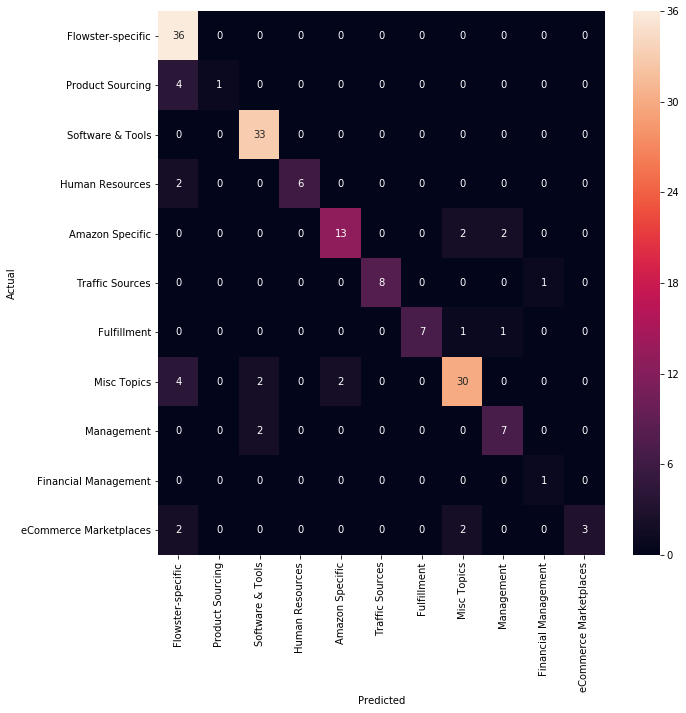

In [164]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=categories, yticklabels=categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

- There are some topics from `Misc Topics`that get misclassified as `Flowster Specific` or `Software & Tools` or `Amazon Specific`.
- We can catch that as well for `Amazon Specific` that gets classified as `Management`.  
It would be interesting to understand why is this so.

In [169]:
X_test

275    bobg brand contact preview page hi wondering a...
93     mitch iphone 11 scan upc codes properly recent...
6      zaid black box amazon product research yay nay...
167    kane links template flowster make link inside ...
90     bobg thoughts chasing price hi new wholesale p...
                             ...                        
407    kane opinion completed py46 appearing calendar...
16     mitch sending mass email gmass hi send mass em...
484    janeen dynamic bidding xtappprocessevent add p...
370    gianmelishanghai us based warehouse nannygate ...
3      jimwpb virtual assistants anyone va recommend ...
Name: post, Length: 172, dtype: object

In [192]:
# Text from Product Sourcing category, Link : https://forum.flowster.app/t/price-checker-2-competitor-storefront-extraction/1411
# 1. Clean text
new_text = 'Hi! We are new to the forum and are going through the Product Sourcing for Professionals SOPs. We have a question on the Product Extraction workflow process using PC2: we have downloaded the free version and it doesn’t have the button that says ‘Amazon Browser/Searches’. Do we need to purchase the full PC2 package to get this feature? Thanks for your help in advance!'
#cleaned_text = clean_text(new_text)

In [193]:
# 2. Vectorize the text + 3. Predict the category
predict_test = logreg.predict([new_text])

In [199]:
print(predict_test)

['Product Sourcing']


In [200]:
test_text = "Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."
predict_test = logreg.predict([test_text])
print(predict_test)

['Flowster-specific']


In [210]:
res = result['post'][result['Category'] == 'Flowster-specific']

In [218]:
res.head()

127    system flowsterspecific category discussion fl...
128    system welcome flowster community looking help...
129    kane wordpresslike template editing control tr...
130    kane cold email outreach 12 get https inflowst...
131    kevin converting twf scouting sourcing spreads...
Name: post, dtype: object

In [223]:
print(res[:1])

127    system flowsterspecific category discussion fl...
Name: post, dtype: object
